In [1]:
import os

import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from skimage import io, transform

from models import DVBPR
from utils.data import extract_embedding
from utils.metrics import (
    auc_exact,
    nDCG,
    precision,
    recall,
    reciprocal_rank,
)


/MindsDB/nenv/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# Evaluation procedure

In [2]:
DATASET = "Wikimedia"

# Model
MODEL = "DVBPR"
assert MODEL in ["DVBPR"]

FEATURE_EXTRACTOR = "resnet50"
assert FEATURE_EXTRACTOR in ["alexnet", "vgg16", "resnet50"]


In [3]:
# Mode
# Use 'MODE_PROFILE = True' for CuratorNet-like training 
# Use 'MODE_PROFILE = False' for VBPR-like training
MODE_PROFILE = MODEL in ["CuratorNet"]
MODE_PROFILE = "profile" if MODE_PROFILE else "user"

# Checkpoint (ex. 'VBPR_wikimedia')
CHECKPOINT = "DVBPR_wikimedia"#_1epoch"


In [4]:
# Paths (general)
CHECKPOINT_PATH = os.path.join("checkpoints", f"{CHECKPOINT}.tar")
EMBEDDING_PATH = os.path.join("data", f"embedding-{FEATURE_EXTRACTOR}.npy")
EVALUATION_PATH = os.path.join("data", f"naive-{MODE_PROFILE}-evaluation.csv")
IMG_PATH = os.path.join("data", "mini-images-224-224-v2", "mini-images-224-224-v2")

# Paths (images)
IMAGES_DIR = os.path.join("/", "mnt", "data2", "wikimedia", "imagenes_tarea")

# General constants
RNG_SEED = 0
USE_GPU = True


In [5]:
[os.path.join(IMG_PATH, path) for path in os.listdir(IMG_PATH)]

['data/mini-images-224-224-v2/mini-images-224-224-v2/201706018.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/201612140.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/200808182.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/201410139.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/201107057.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/201310216.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/201201033.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/200806161.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/201503025.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/200706121.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/200709163.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/201111141.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/201402162.jpg',
 'data/mini-images-224-224-v2/mini-images-224-224-v2/201406021.jpg',
 'data/mini-images-224-224-v2/mini

In [6]:
# Freezing RNG seed if needed
if RNG_SEED is not None:
    print(f"\nUsing random seed... ({RNG_SEED})")
    torch.manual_seed(RNG_SEED)



Using random seed... (0)


In [7]:
# Load embedding from file
print(f"\nLoading embedding from file... ({EMBEDDING_PATH})")
embedding = np.load(EMBEDDING_PATH, allow_pickle=True)

# Extract features and "id2index" mapping
print("\nExtracting data into variables...")
features, id2index, item_index2fn = extract_embedding(embedding, verbose=True)
print(f">> Features shape: {features.shape}")
del embedding  # Release some memory



Loading embedding from file... (data/embedding-resnet50.npy)

Extracting data into variables...
>> Features shape: (9633, 2048)


In [8]:
# Load evaluation dataframe
print("\nLoad evaluation dataframe")
evaluation_df = pd.read_csv(EVALUATION_PATH)
# Transform lists from str to int
string_to_list = lambda s: list(map(int, s.split()))
evaluation_df["profile"] = evaluation_df["profile"].apply(
    lambda s: string_to_list(s) if isinstance(s, str) else s,
)
evaluation_df["predict"] = evaluation_df["predict"].apply(
    lambda s: string_to_list(s) if isinstance(s, str) else s,
)
# Group evaluations by profile and user
evaluation_df["profile"] = evaluation_df["profile"].map(tuple)
evaluation_df = evaluation_df.groupby(["profile", "user_id"]).agg({"predict": sum}).reset_index()
evaluation_df["profile"] = evaluation_df["profile"].map(list)
print(f">> Evaluation: {evaluation_df.shape}")



Load evaluation dataframe
>> Evaluation: (1078, 3)


In [9]:
evaluation_df

,profile,user_id,predict
0,"[8, 2716, 2717, 2708, 2719, 2715, 2721]",682,2722
1,"[14, 4557, 4554, 4553, 4541, 4551, 4556, 4558,...",915,4720
2,"[21, 9519, 9532, 9518, 9524, 9515, 9528, 9522,...",1077,9533
3,"[22, 25, 44, 39, 233, 213, 294, 437, 447]",26,449
4,"[22, 25, 117, 121, 122, 120, 123]",9,125
...,...,...,...
1073,"[9593, 5307, 5318, 5301, 5306, 9062, 9050, 906...",153,9092
1074,"[9602, 9601, 9604, 9603, 6531, 9605, 6545, 654...",968,6717
1075,"[9617, 9627, 9625, 9623, 9616, 9615, 9628, 961...",1032,9629
1076,"[9618, 8157, 8811, 8841, 9355, 9373, 9365, 936...",703,9386


In [10]:
# Create device instance
print("\nDevice initialization")
device = torch.device("cuda:0" if torch.cuda.is_available() and USE_GPU else "cpu")
if torch.cuda.is_available() != USE_GPU:
    print((f"\nNotice: Not using GPU - "
           f"Cuda available ({torch.cuda.is_available()}) "
           f"does not match USE_GPU ({USE_GPU})"
    ))

# Loading checkpoint
if CHECKPOINT is not None:
    print("\nLoading checkpoint")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device("cpu"))
    print(f">> Best epoch: {checkpoint['epoch']} | Best accuracy: {checkpoint['accuracy']}")

# Model initialization
print("\nModel initialization")
model = None
if MODEL == "DVBPR":
    n_users = checkpoint["model"]["theta_users.weight"].size(0)
    #n_items = checkpoint["model"]["gamma_items.weight"].size(0)
    dim_theta = checkpoint["model"]["theta_users.weight"].size(1)
    model = DVBPR(
        n_users, # n_items
        features, # DEBUGGING, ERASE LATER
        K=dim_theta,  # Size of internal spaces
    ).to(device)

# Load state dict
if CHECKPOINT is not None:
    model.load_state_dict(checkpoint["model"])

# Change model mode to eval
print("\nChanging model mode to eval")
model.eval()



Device initialization

Loading checkpoint
>> Best epoch: 1 | Best accuracy: 0.8822105397718194

Model initialization

Changing model mode to eval


DVBPR(
  (cnn): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Li

In [11]:
next(model.parameters()).is_cuda

True

In [12]:
# Predict all
# If True, ranks every item including already consumed items
# If False, ranks ALL - PROFILE (consumed) + PREDICT (ground truth)
PREDICT_ALL = False

In [13]:
from datasets.user_mode_img import Rescale, ToTensor

rescaler = Rescale(224)
tensorizer = ToTensor()

def getimg(path, rescaler, tensorizer):
    img = io.imread(path)
    # img = rescaler(img)
    return tensorizer(img)

In [14]:
%%time
# Metrics
N_EVALS = len(evaluation_df.index)
# Area Under the Curve (AUC)
AUC = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Reciprocal Rank (RR)
RR = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Recall
R20 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
R100 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
R200 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Precision
P20 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
P100 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
P200 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Normalized discounted cumulative gain (nDCG)
N20 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
N100 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
N200 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
PROFILE_SIZES = torch.zeros([N_EVALS], dtype=int, device=device)
N_ITEMS = len(features)

CPU times: user 1.69 ms, sys: 36 µs, total: 1.72 ms
Wall time: 840 µs


In [15]:
imglist = []
for path in tqdm(os.listdir(IMG_PATH)):
    if path in item_index2fn.values():
        img = getimg(os.path.join(IMG_PATH, path), rescaler, tensorizer) 
        imglist.append(img)
        
assert len(imglist) == N_ITEMS

In [16]:
def generate_cache(model, img_list, grad_enabled=False, device='cuda'):
    cache = []
    with torch.set_grad_enabled(grad_enabled):
        for img in tqdm(img_list):
            img = img.to(device).unsqueeze(0)
            cache.append(model.cnn(img))
        return torch.stack(cache)

cache = generate_cache(model, imglist, device=device).to(device)

In [17]:
#model.cnn.convs[0].weight.sum()
model.cnn(imglist[0].to(device).unsqueeze(0))

tensor([[ 0.2632, 19.2194,  0.7984, -0.2366, -1.6851,  0.0285, -0.4981,  0.2017,
          6.2592, -1.4275, -1.7317, -1.3909, -2.5200, -0.2664,  3.7022,  0.3330,
          0.0887,  0.4927,  0.4566,  1.1528,  1.9945, -0.9424,  0.5559,  0.5011,
         -7.1123,  0.9575,  1.1659,  1.8746,  0.0339,  0.1864,  0.2478,  1.8232,
          0.1223,  0.2489, -0.5666, -0.2940,  1.3934,  6.4044, -0.0445,  3.3233,
         -1.0702,  5.5206,  0.3187,  0.7613,  2.0365,  0.1103,  0.1405, -1.6988,
          0.9277,  0.9414]], device='cuda:0', grad_fn=<AddmmBackward>)

In [18]:
# cache = torch.Tensor(features).to(device) # for tests with embeddings from frozen resnet (VBPR)
# del(imglist)

In [20]:
import torch
def dvbpr_recommend_all(model, user, cache=None, grad_enabled=False):
    with torch.set_grad_enabled(grad_enabled):
        #print(user)
        # User
        u_visual_factors = model.theta_users(user)  # Visual factors of user u
        u_bias = model.beta_users(user).squeeze()
        # Items
        #print(u_visual_factors.shape)
        #print(cache.shape)
        visual_rating_space = cache#[user]
        #print(visual_rating_space.shape)

        x_ui = (u_bias + (u_visual_factors * visual_rating_space).sum(dim=2)).squeeze()
        #print(x_ui.shape)
        #print(x_ui)
        #print(x_ui.min())
        #print(x_ui.max())
        #print(x_ui.mean())
        #print(x_ui.std())
        return x_ui.squeeze()

In [21]:
#all_evaluation_df = evaluation_df
#evaluation_df = all_evaluation_df  # evaluation_df[evaluation_df['user_id'].isin([0, 1, 2, 3])]
PREDICT_ALL

False

In [22]:
evaluation_df["profile"] = evaluation_df["profile"].map(tuple)
grouped_evals = evaluation_df.groupby(["profile", "user_id"]).agg({"predict": sum}).reset_index()
for i, row in tqdm(enumerate(evaluation_df.itertuples()), total=len(evaluation_df.index)):
    # Load data into tensors
    profile = torch.tensor(row.profile).to(device, non_blocking=True)#.unsqueeze(0)
    user_id = torch.tensor([int(row.user_id)]).to(device, non_blocking=True)
    predict = torch.tensor(row.predict).to(device, non_blocking=True)
    #print(predict.shape)
    #print(N_ITEMS)
    # Prediction
    if MODE_PROFILE == "profile":
        scores = dvbpr_recommend_all(model, profile, cache=cache)
    elif MODE_PROFILE == "user":
        scores = dvbpr_recommend_all(model, user_id, cache=cache)#.squeeze()
    # print(scores)#.shape)#[predict])
    # Ranking
    #input()
    pos_of_evals = (torch.argsort(scores, descending=True)[..., None] == predict).any(-1).nonzero().flatten()
    if not PREDICT_ALL:
        pos_of_profi = (torch.argsort(scores, descending=True)[..., None] == profile).any(-1).nonzero().flatten()
        # Relevant dimensions
        _a, _b = pos_of_evals.size(0), pos_of_profi.size(0)
        # Calculate shift for each eval item
        shift = (pos_of_profi.expand(_a, _b) < pos_of_evals.reshape(_a, 1).expand(_a, _b)).sum(1)
        # Apply shift
        pos_of_evals -= shift.squeeze(0)
    # print(pos_of_evals)
    #input()
    # Store metrics
    AUC[i] = auc_exact(pos_of_evals, N_ITEMS)
    RR[i] = reciprocal_rank(pos_of_evals)
    R20[i] = recall(pos_of_evals, 20)
    P20[i] = precision(pos_of_evals, 20)
    N20[i] = nDCG(pos_of_evals, 20)
    R100[i] = recall(pos_of_evals, 100)
    P100[i] = precision(pos_of_evals, 100)
    N100[i] = nDCG(pos_of_evals, 100)
    R200[i] = recall(pos_of_evals, 200)
    P200[i] = precision(pos_of_evals, 200)
    N200[i] = nDCG(pos_of_evals, 200)
    PROFILE_SIZES[i] = len(row.profile)

<ipython-input-22-927754750e33>:18: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  pos_of_evals = (torch.argsort(scores, descending=True)[..., None] == predict).any(-1).nonzero().flatten()


In [23]:
# Display stats
print(f"AVG AUC = {AUC.mean()}")
print(f"AVG RR = {RR.mean()}")
print(f"AVG R20 = {R20.mean()}")
print(f"AVG P20 = {P20.mean()}")
print(f"AVG NDCG20 = {N20.mean()}")
print(f"AVG R100 = {R100.mean()}")
print(f"AVG P100 = {P100.mean()}")
print(f"AVG NDCG100 = {N100.mean()}")
print(f"AVG R200 = {R200.mean()}")
print(f"AVG P200 = {P200.mean()}")
print(f"AVG NDCG200 = {N200.mean()}")


AVG AUC = 0.5014571521243604
AVG RR = 0.0005504259496081916
AVG R20 = 0.0
AVG P20 = 0.0
AVG NDCG20 = 0.0
AVG R100 = 0.0027829313767142594
AVG P100 = 2.7829313767142592e-05
AVG NDCG100 = 0.0004911287249926957
AVG R200 = 0.01298701309133321
AVG P200 = 6.493506545666606e-05
AVG NDCG200 = 0.0019179132436299659


In [ ]:
"""
5 epochs:
AVG AUC = 0.5605302060878625
AVG RR = 0.0010978371958718018
AVG R20 = 0.0009276437922380865
AVG P20 = 4.638218961190433e-05
AVG NDCG20 = 0.0002926390346194341
AVG R100 = 0.01298701309133321
AVG P100 = 0.0001298701309133321
AVG NDCG100 = 0.0025044414474417074
AVG R200 = 0.02875695755938068
AVG P200 = 0.0001437847877969034
AVG NDCG200 = 0.004691743150511971
"""

## Relevant plots

In [24]:
import numpy as np


def smart_group(value):
    if value == 0:
        return 0
    digits = int(np.log10(value)) + 1
    return (10**(digits - 1)) * (value // (10**(digits - 1)))

In [25]:
import pandas as pd


metrics_data = [
    [
        PROFILE_SIZES[i].item(), AUC[i].item(), RR[i].item(),
        R20[i].item(), P20[i].item(), N20[i].item(),
        R100[i].item(), P100[i].item(), N100[i].item(),
    ]
    for i in range(N_EVALS)
]
metrics_df = pd.DataFrame(metrics_data, columns=[
    "PROFILE_SIZES", "AUC", "RR",
    "R20", "P20", "N20",
    "R100", "P100", "N100",
])
metrics_df["PROFILE_SIZES_STEPS"] = metrics_df["PROFILE_SIZES"].map(smart_group)

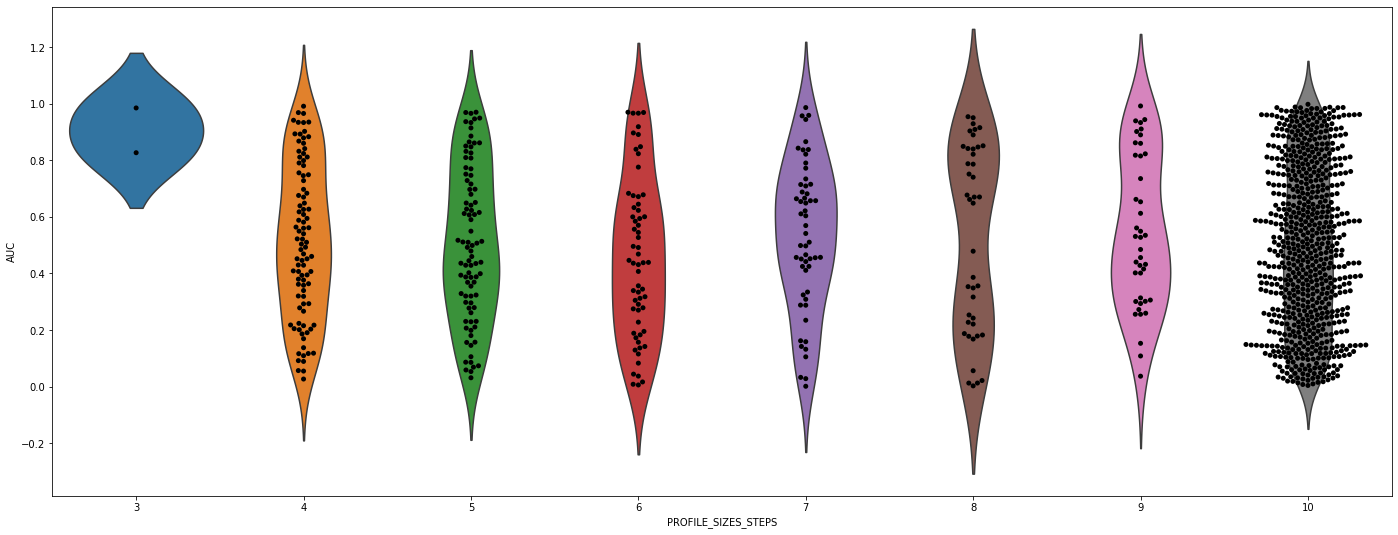

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


# Metric
METRIC = "AUC"
# Profile size range
metrics_df_plot = metrics_df.copy()
metrics_df_plot = metrics_df_plot[
    (metrics_df_plot["PROFILE_SIZES_STEPS"] >= 0) & (metrics_df_plot["PROFILE_SIZES_STEPS"] < 100)
]
# Plot METRIC distribution across users grouped by profile size
plt.figure(figsize=(24, 9))
ax = sns.violinplot(x="PROFILE_SIZES_STEPS", y=METRIC, data=metrics_df_plot, inner=None)
if DATASET != "Pinterest":
    ax = sns.swarmplot(x="PROFILE_SIZES_STEPS", y=METRIC, data=metrics_df_plot, color="black", edgecolor="gray")


<AxesSubplot:>

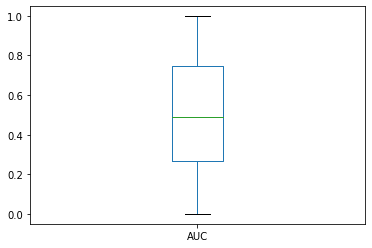

In [27]:
# Area Under the Curve distribution across users
metrics_df["AUC"].plot.box(sym="r+")

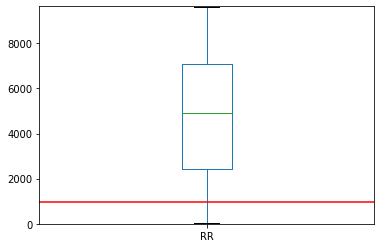

In [28]:
# First relevant item position (1 / reciprocal_rank) distribution across users
# Line marks the 10% of the dataset
graph = (1 / metrics_df["RR"]).plot.box(sym="r+")
plt.ylim(0, features.shape[0])
graph.axhline(features.shape[0] / 10, color="red")

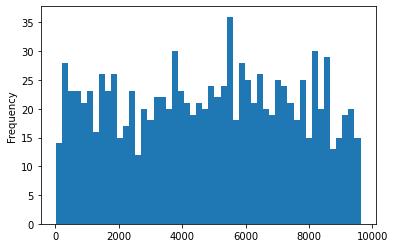

In [29]:
# First relevant item position (1 / reciprocal_rank) histogram
graph = (1 / metrics_df["RR"]).plot.hist(bins=50)

## Results inspection

In [45]:
ROW = 6

In [46]:
# Row in evaluation dataframe
row = evaluation_df.iloc[ROW]

# Load data into tensors
profile = torch.tensor(row.profile).to(device, non_blocking=True).unsqueeze(0)
user_id = torch.tensor([int(row.user_id)]).to(device, non_blocking=True)
predict = torch.tensor(row.predict).to(device, non_blocking=True)
# Prediction
print(user_id)
scores = dvbpr_recommend_all(model, user_id, cache=cache).squeeze()
# Ranking
pos_of_evals = (torch.argsort(scores, descending=True)[..., None] == predict).any(-1).nonzero().flatten()
if not PREDICT_ALL:
    pos_of_profi = (torch.argsort(scores, descending=True)[..., None] == profile).any(-1).nonzero().flatten()
    pos_of_evals -= (pos_of_profi < pos_of_evals).sum()

# Display metrics
print(f"| {'-' * 15} | {'-' * 7} |")
print(f"| {'Metric':^15} | {'Score':^7} |")
print(f"| {'-' * 15} | {'-' * 7} |")
print(f"| {'AUC':^15} | {auc_exact(pos_of_evals, N_ITEMS):.5f} |")
print(f"| {'RR':^15} | {reciprocal_rank(pos_of_evals):.5f} |")
for k in [20, 100, 500]:
    print(f"| {'-' * 15} | {'-' * 7} |")
    print(f"| {f'Recall@{k}':^15} | {recall(pos_of_evals, k):.5f} |")
    print(f"| {f'Precision@{k}':^15} | {precision(pos_of_evals, k):.5f} |")
    print(f"| {f'nDCG@{k}':^15} | {nDCG(pos_of_evals, k):.5f} |")
print(f"| {'-' * 15} | {'-' * 7} |")

# Profile and prediction
profile = profile.cpu().numpy().flatten()
predict = predict.cpu().numpy().flatten()
# Ranking
K = 26
ranking = torch.argsort(scores, descending=True).cpu().numpy().flatten()
if not PREDICT_ALL:
    ranking = ranking[(~np.isin(ranking, profile)) | (np.isin(ranking, predict))]
ranking = ranking[:K]
print()
print(f"Size of profile: {profile.size}")
print(f"Position of actual items: {pos_of_evals.cpu().numpy()}")


tensor([34], device='cuda:0')
| --------------- | ------- |
|     Metric      |  Score  |
| --------------- | ------- |
|       AUC       | 0.96615 |
|       RR        | 0.00306 |
| --------------- | ------- |
|    Recall@20    | 0.00000 |
|  Precision@20   | 0.00000 |
|     nDCG@20     | 0.00000 |
| --------------- | ------- |
|   Recall@100    | 0.00000 |
|  Precision@100  | 0.00000 |
|    nDCG@100     | 0.00000 |
| --------------- | ------- |
|   Recall@500    | 1.00000 |
|  Precision@500  | 0.00200 |
|    nDCG@500     | 0.11965 |
| --------------- | ------- |

Size of profile: 6
Position of actual items: [326]


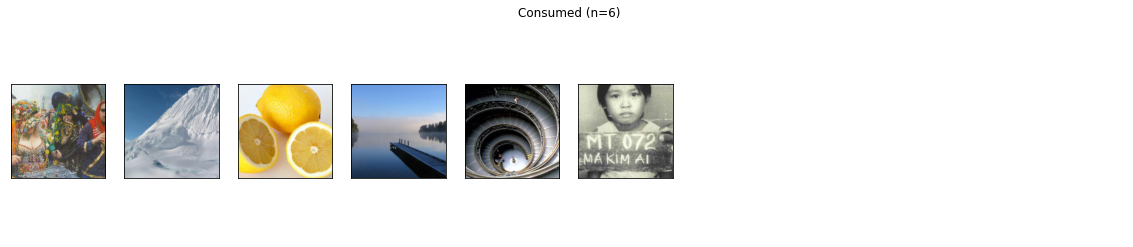

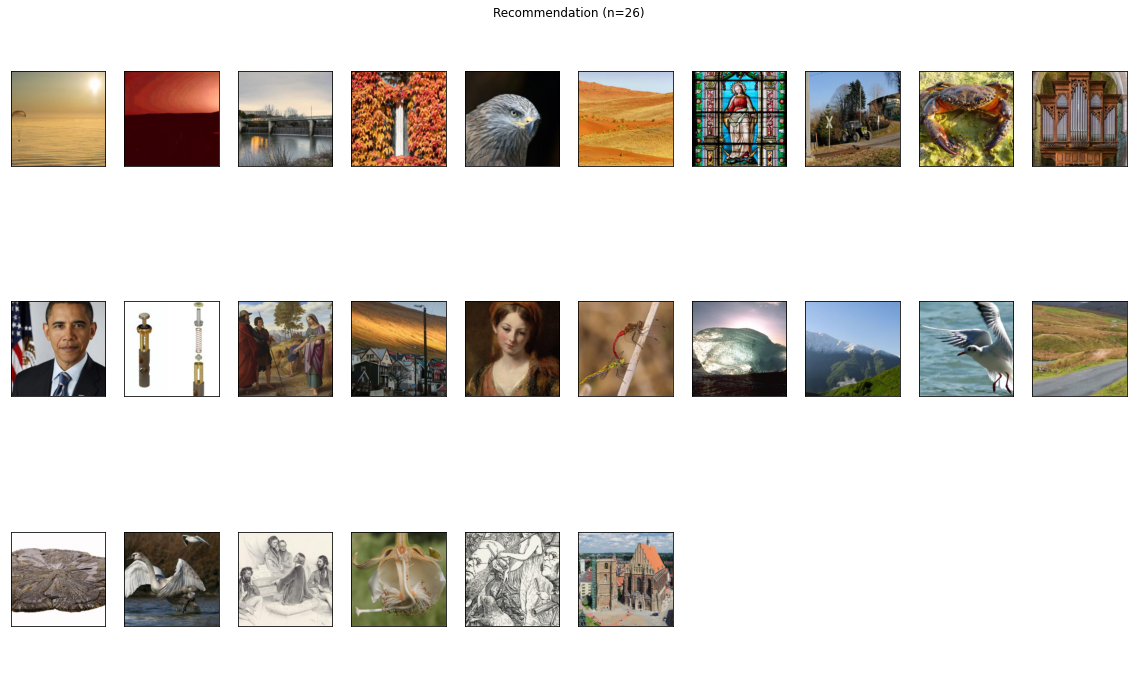

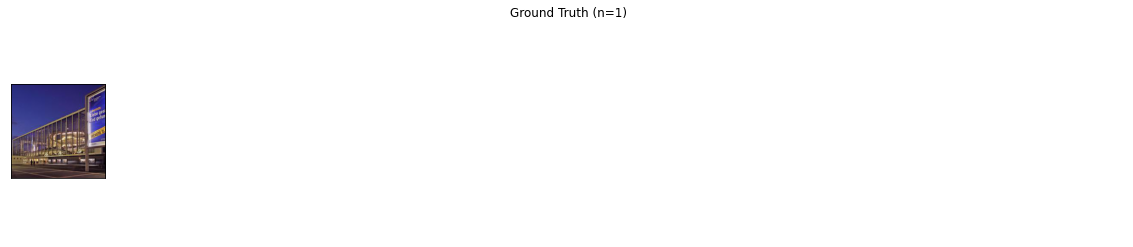

In [47]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


COLUMNS = 10
ELEMENTS = {
    "Consumed": profile,
    "Recommendation": ranking,
    "Ground truth": predict,
}
SHOW_FILENAME = False

for label, items in ELEMENTS.items():
    n_rows = ((len(items) - 1) // COLUMNS + 1)
    fig = plt.figure(figsize=(COLUMNS * 2, 4 * n_rows))
    plt.title(f"{label.title()} (n={len(items)})")
    plt.axis("off")
    for i, img_id in enumerate(items, start=1):
        img_fn = item_index2fn[img_id]
        image = mpimg.imread(os.path.join(IMG_PATH, img_fn))
        ax = fig.add_subplot(n_rows, COLUMNS, i)
        if SHOW_FILENAME:
            ax.set_title(img_fn)
        if label == "Recommendation":
            if img_id in predict:
                ax.patch.set_edgecolor("green")
                ax.patch.set_linewidth("5")
                if SHOW_FILENAME:
                    ax.set_title(img_fn, color="green")
                else:
                    ax.set_title("Ground truth", color="green")
            elif img_id in profile:
                ax.patch.set_edgecolor("red")
                ax.patch.set_linewidth("5")
                if SHOW_FILENAME:
                    ax.set_title(img_fn, color="red")
                else:
                    ax.set_title("Consumed", color="red")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)


In [ ]:
# Conclusion: both models predict exactly the same, might be b/c of completely unaware image information?